#  Gravitational Wave Data Analysis tutorial #1


#### Tutorial 1.1: Discovering open data from GW observatories

This notebook describes how to discover what data are available from the [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/SylvainMarsat/gwda_tutorial/blob/main/tutorial_1.ipynb)

Author date

## Install

When running in Google Colab, uncomment and run the cell to install required packages:

In [ ]:
#! pip install numpy scipy h5py matplotlib ipython jupyterlab tqdm lalsuite gwpy

When running in Google Colab, uncomment and run the cell to download the required data:

In [ ]:
#! mkdir data
#! wget https://www.github.com/SylvainMarsat/gwda_tutorial/blob/main/data/H-H1_LOSC_4_V2-1126259446-32.hdf5 -P data/

When running in Google Colab, uncomment and run the cell to install latex for matplotlib:

In [ ]:
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

## Imports

In [1]:
import os, sys
import h5py, json
import copy
import numpy as np
import scipy
import astropy
import astropy.units as u
import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab

import gwosc
import gwpy

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio") # to silence a warning
import lal
import lalsimulation
import lalsimulation.gwsignal.core.waveform as wfm
from lalsimulation.gwsignal import gwsignal_get_waveform_generator

from tqdm import tqdm as tqdm

/Users/marsat/miniconda3/envs/odw/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [3]:
plt.rcParams.update({'figure.dpi': 100})

In [6]:
losc_dir = '/Users/marsat/Projects/tutorials/gwda/LOSC_Event_tutorial/'

In [16]:
sys.path.append(losc_dir)

import readligo as rl

In [39]:
%matplotlib inline

In [89]:
colors = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD", '#FFA500', '#A0522D']

rc_params = {'backend': 'ps',
            'axes.unicode_minus':False,
            'axes.grid':True,
            'lines.linewidth':1,
            'grid.linestyle':':',
            'grid.linewidth':1.,
            'hist.bins':50,
            'axes.labelsize':16,
            'axes.titlesize':16,
            'xtick.labelsize':16,
            'ytick.labelsize':16,
            'legend.fontsize':16,
            'figure.dpi':100}
plt.rcParams.update(rc_params)

In [88]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': False,
          'axes.edgecolor': 'gray',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-3, 4],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': True,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',
       

## Definitions

In [169]:
# Definitions for the windowing function -- function for vectorial argument
# In order to avoid overflows in the exponentials, we set the boundaries (di, df) so that anything below 10^-20 is considered zero
def window_planck(x, xi, xf, deltaxi, deltaxf):
    di = deltaxi/(20*np.log(10))
    df = deltaxf/(20*np.log(10))
    w = np.zeros(len(x), dtype=float)
    #
    mask = (x <= xi + di) | (x >= xf - df)
    w[mask] = 0.
    #
    mask = (xi + di < x) & (x < xi + deltaxi - di)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(deltaxi/(xm - xi) + deltaxi/(xm - (xi + deltaxi))))
    #
    mask = (xi + deltaxi - di <= x) & (x <= xf - deltaxf + df)
    w[mask] = 1.
    #
    mask = (xf - deltaxf + df < x) & (x < xf - df)
    xm = x[mask]
    w[mask] = 1./(1 + np.exp(-(deltaxf/(xm - (xf - deltaxf))) - deltaxf/(xm - xf)))
    #
    return w

In [170]:
def fft_positivef(times, data):
    n = len(times)
    deltat = times[1] - times[0]
    deltaf = 1./(n*deltat)
    # Fast Fourier Transform
    freqs = deltaf*np.arange(n)
    # BEWARE: due to the different convention for the sign of Fourier frequencies, we have to reverse the FFT output
    # Beware also that the FFT treats effectively the initial time as 0
    # BEWARE: in the reversion of the numpy-convention FFT output, we have to set aside the 0-frequency term
    data_fd = deltat * np.fft.fft(data)
    # Discarding information on negative frequencies - if real timeseries in input, no information loss as the deleted values are the conjugate
    data_fd = data_fd[:n//2+1]
    freqs = freqs[:n//2+1]
    # Coming back to the initial times
    tshift = times[0]
    fac_timeshift = np.exp(1j*2*np.pi*freqs*tshift)
    data_fd = data_fd * fac_timeshift
    return freqs, data_fd

In [171]:
def zeropad(times, data, extend=0):
    n = len(times)
    n_pad = 2**(int(ceiling(n / np.log(2))) + extend)
    dt = times[1] - times[0]
    times_pad = times[0] + dt * np.arange(n_pad)
    data_pad = np.zeros(n_pad, dtype=data.dtype)
    data_pad[:n] = data
    return times_pad, data_pad

In [8]:
# Read the event properties from a local json file
fnjson = losc_dir + 'BBH_events_v3.json'
events = json.load(open(fnjson, 'r'))

eventname = 'GW150914'
# eventname = 'GW151226'
events[eventname]

{'name': 'GW150914',
 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5',
 'fn_template': 'GW150914_4_template.hdf5',
 'fs': 4096,
 'tevent': 1126259462.44,
 'utcevent': '2015-09-14T09:50:45.44',
 'm1': 41.743,
 'm2': 29.237,
 'a1': 0.355,
 'a2': -0.769,
 'approx': 'lalsim.SEOBNRv2',
 'fband': [43.0, 300.0],
 'f_min': 10.0}

In [9]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

In [8]:
def psd_smooth(freqs):
    return (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2

# Part I: visualizing CBC signals

## Time-domain signals

$$ p(\theta | d, M_s) = \frac{\mathcal{L}(d| \theta, M_s) \;\pi(\theta | M_s)}{\mathcal{Z}(d | M_s)} $$

In [126]:
def gwsignal_GenerateTDModes(m1, m2, chi1, chi2, dist=1e3, f_min=10., f_ref=10., f_Nyquist=1024., phi_ref=0., approximant='IMRPhenomTPHM'):
    
    python_dict = {'mass1' : m1*u.solMass,
                  'mass2' : m2*u.solMass,
                  'spin1x' : chi1[0]*u.dimensionless_unscaled,
                  'spin1y' : chi1[0]*u.dimensionless_unscaled,
                  'spin1z' : chi1[0]*u.dimensionless_unscaled,
                  'spin2x' : chi2[0]*u.dimensionless_unscaled,
                  'spin2y' : chi2[1]*u.dimensionless_unscaled,
                  'spin2z' : chi2[2]*u.dimensionless_unscaled,
                  'deltaT' : 1./(2*f_Nyquist)*u.s,
                  'f22_start' : f_min*u.Hz,
                  'f22_ref': f_ref*u.Hz,
                  'phi_ref' : phi_ref*u.rad,
                  'distance' : dist*u.Mpc,
                  # 'inclination' : inclination,
                  'eccentricity' : 0.*u.dimensionless_unscaled,
                  'longAscNodes' : 0.*u.rad,
                  'meanPerAno' : 0.*u.rad,
                    'condition': 0}

    gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator('IMRPhenomTPHM')

    hlm_ts = wfm.GenerateTDModes(python_dict, gen)

    t = hlm_ts['time_array']
    modes = [k for k in hlm_ts.keys() if not k=='time_array']

    hlm = {}
    hlm['modes'] = modes
    hlm['t'] = t
    for lm in modes:
        hlm[lm] = np.asarray(hlm_ts[lm])

    return hlm

In [127]:
hlm = gwsignal_GenerateTDModes(40., 30., [0., 0., 0.], [0., 0., 0.], f_min=15., f_ref=15.)

In [128]:
hlm.keys()

dict_keys(['modes', 't', (2, -2), (2, -1), (2, 0), (2, 1), (2, 2), (3, -3), (3, -2), (3, -1), (3, 0), (3, 1), (3, 2), (3, 3), (4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, -5), (5, -4), (5, -3), (5, -2), (5, -1), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)])

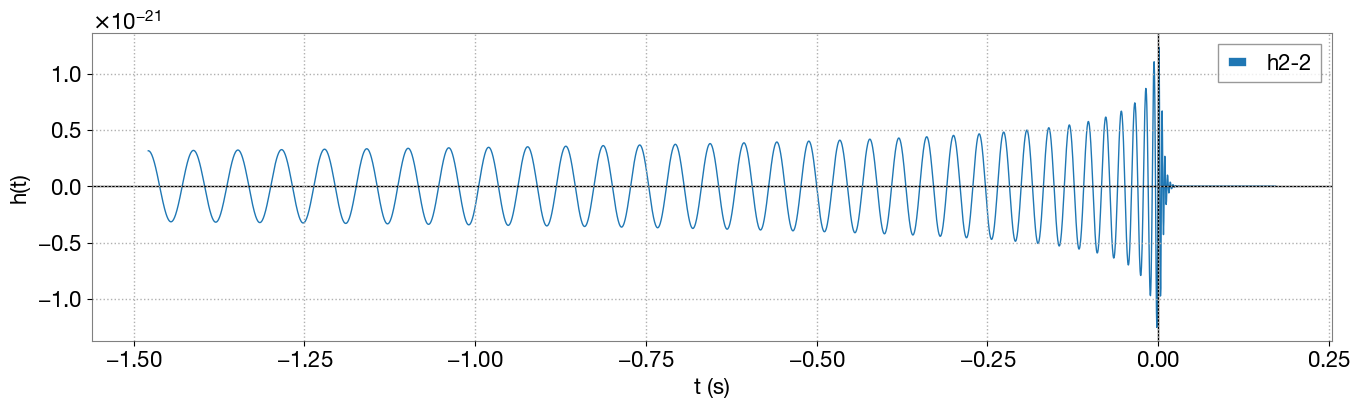

In [119]:
fig, ax = plt.subplots(1,1, figsize=[16,4])

ax.plot(hlm['t'], np.real(hlm[(2,-2)]) , label=r'h2-2')

ax.axhline(0., c='k')
ax.axvline(0., c='k')
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

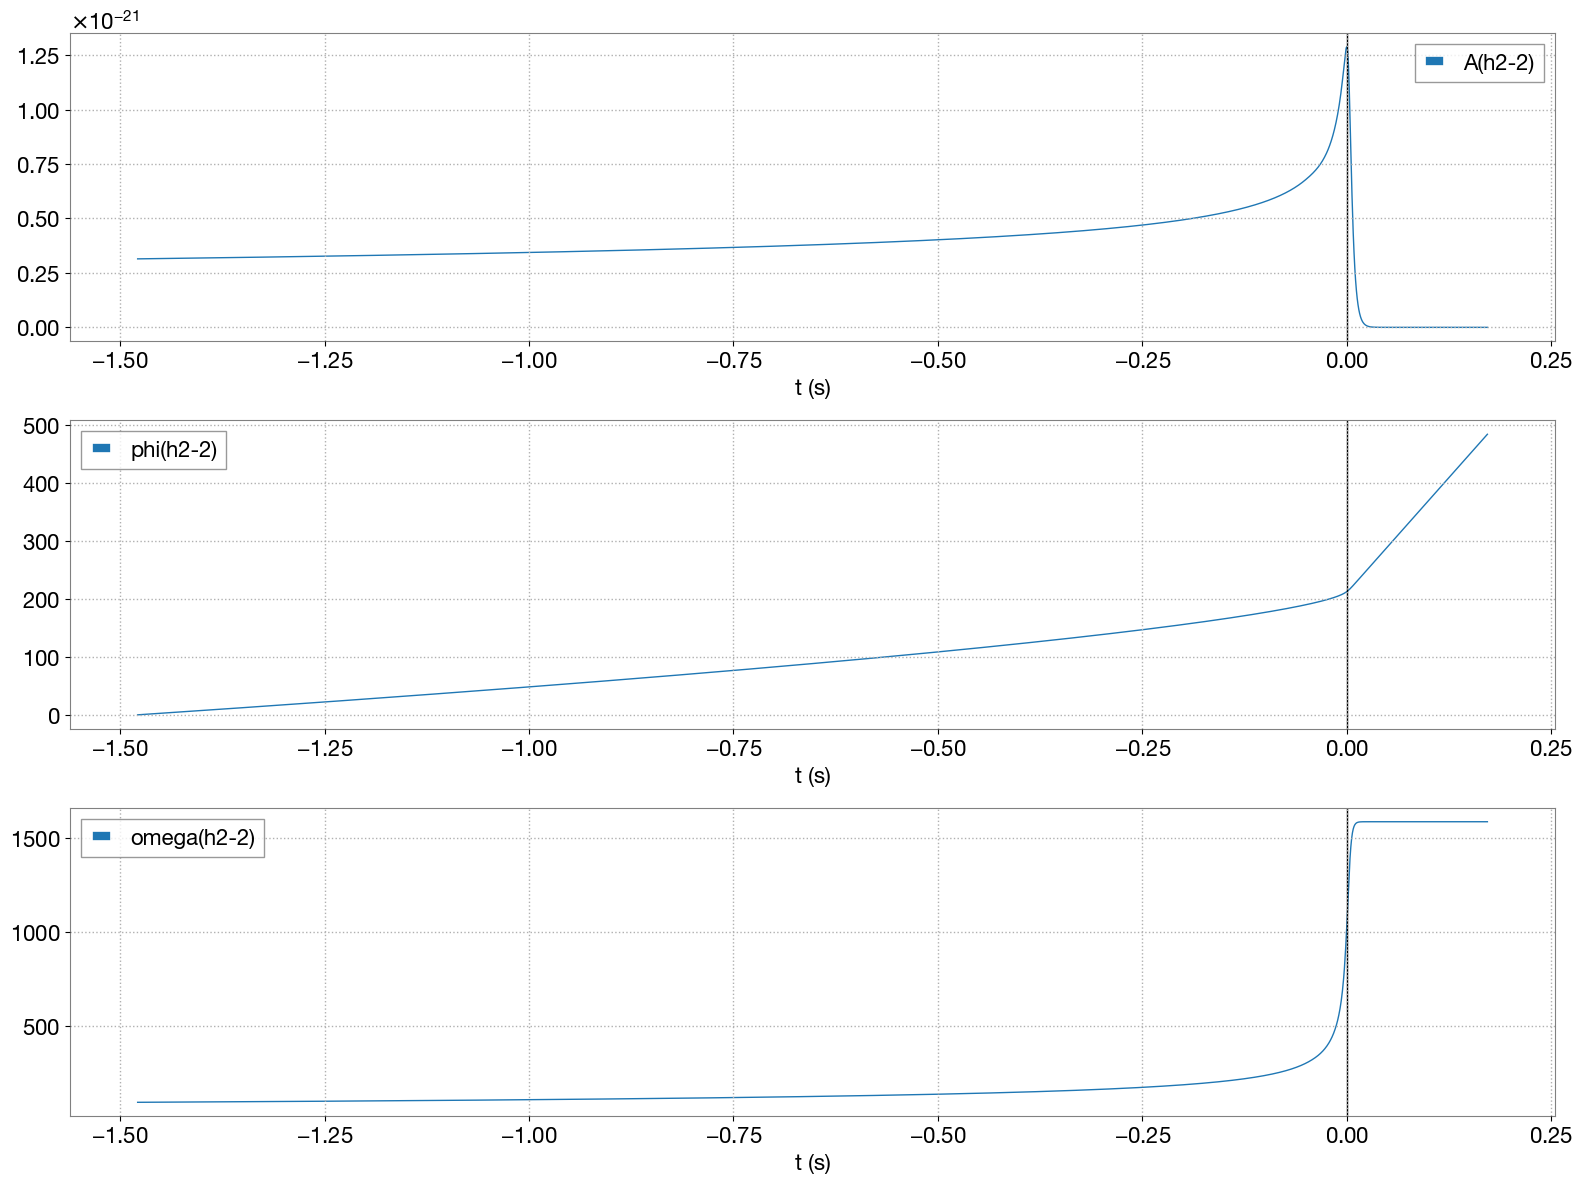

In [120]:
fig, axs = plt.subplots(3,1, figsize=[16,12])

amp = np.abs(hlm[(2,-2)])
phase = np.unwrap(np.angle(hlm[(2,-2)]))
omega = scipy.interpolate.InterpolatedUnivariateSpline(hlm['t'], phase)(hlm['t'], 1)

axs[0].plot(hlm['t'], amp, label=r'A(h2-2)')
axs[1].plot(hlm['t'], phase, label=r'phi(h2-2)')
axs[2].plot(hlm['t'], omega, label=r'omega(h2-2)')

for i in range(3):
    axs[i].axvline(0., c='k')
    axs[i].set_xlabel(r't (s)')
    axs[i].legend(loc='best');

fig.tight_layout()

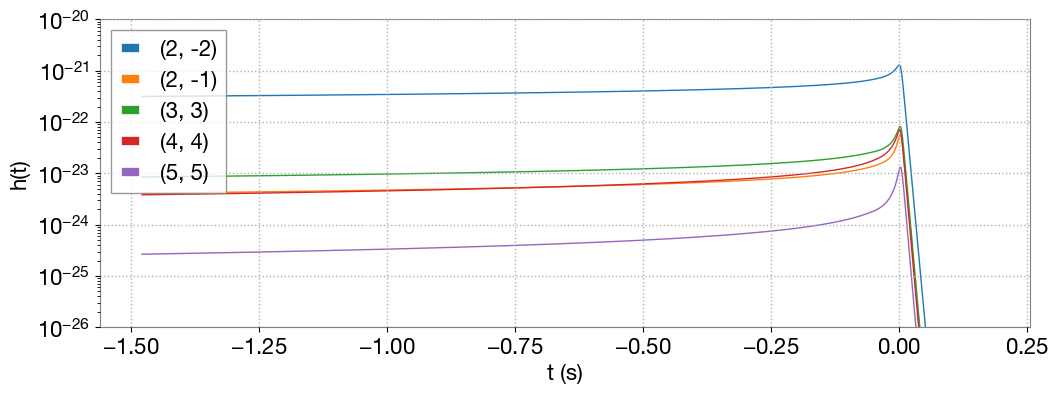

In [144]:
modes_plt = [(2,-2), (2,-1), (3,3), (4,4), (5,5)]

fig, ax = plt.subplots(1,1, figsize=[12,4])

for lm in modes_plt:
    ax.plot(hlm['t'], np.abs(hlm[lm]) , label=r''+str(lm))

ax.set_yscale('log')
ax.set_ylim(1e-26, 1e-20)
ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='upper left');

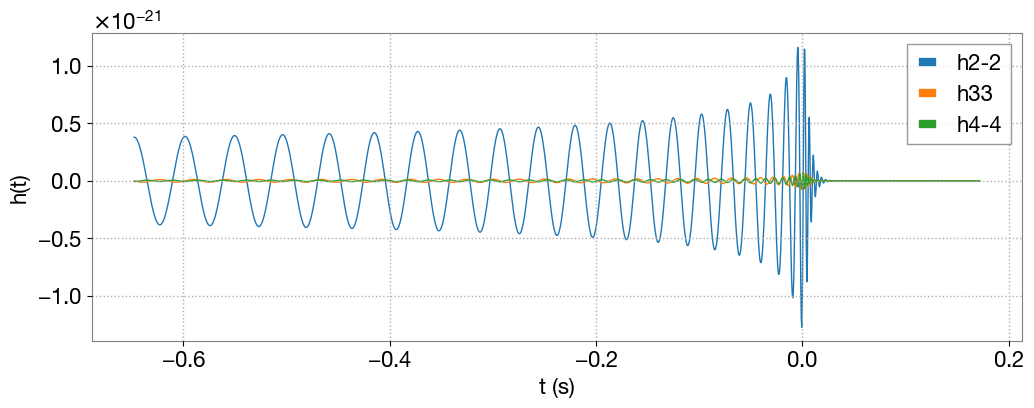

In [96]:
fig, ax = plt.subplots(1,1, figsize=[12,4])

ax.plot(np.real(hlm[(2,-2)]) , label=r'h2-2')
ax.plot(np.real(hlm[(3,3)]) , label=r'h33')
ax.plot(np.real(hlm[(4,-4)]) , label=r'h4-4')

ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.legend(loc='best');

In [23]:
gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator('IMRPhenomTPHM')

In [24]:
hlm = wfm.GenerateTDModes(python_dict, gen)

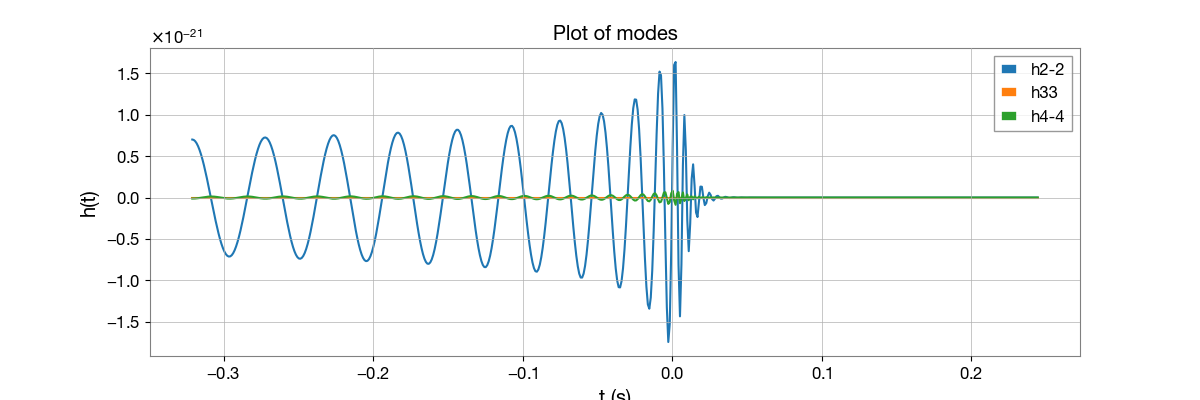

In [25]:
fig, ax = plt.subplots(1,1, figsize=[12,4])

ax.plot(hlm[(2,-2)] , label=r'h2-2')
ax.plot(hlm[(3,3)] , label=r'h33')
ax.plot(hlm[(4,-4)] , label=r'h4-4')

ax.set_xlabel(r't (s)')
ax.set_ylabel(r'h(t)')
ax.set_title(r'Plot of modes')
ax.legend(loc='best');

In [58]:
python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaF' : 1./8*u.Hz,
              'f22_start' : f_min,
              'f22_ref': f_ref,
              'phi_ref' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno,
                'condition': 0}

In [59]:
gen = lalsimulation.gwsignal.gwsignal_get_waveform_generator('IMRPhenomXPHM')

In [60]:
hlm = wfm.GenerateFDModes(python_dict, gen)

In [64]:
hp, hc = wfm.GenerateFDWaveform(python_dict, gen)

In [71]:
np.asarray(hp.frequencies)

array([ 0.   ,  0.125,  0.25 , ..., 31.75 , 31.875, 32.   ],
      shape=(257,))

In [62]:
lalsimulation.SimIMRPhenomXASGenerateFD?

Docstring: SimIMRPhenomXASGenerateFD(REAL8 m1_SI, REAL8 m2_SI, REAL8 chi1L, REAL8 chi2L, REAL8 distance, REAL8 f_min, REAL8 f_max, REAL8 deltaF, REAL8 phiRef, REAL8 fRef_In, Dict lalParams) -> int
Type:      builtin_function_or_method

In [50]:
test = hlm[(2,2)]

In [54]:
np.asarray(hlm['frequency_array'])

array([-512.    , -511.9375, -511.875 , ...,  511.875 ,
        511.9375,  512.    ], shape=(16385,))

In [52]:
np.asarray(test)

array([ 0.00000000e+00+0.00000000e+00j,
       -8.03309446e-30+1.27333862e-29j,
       -8.06374152e-30+1.27508224e-29j, ...,
       -7.62714534e-35+1.93158486e-34j,
       -7.63768621e-35+1.92590355e-34j,
        0.00000000e+00+0.00000000e+00j], shape=(16385,))

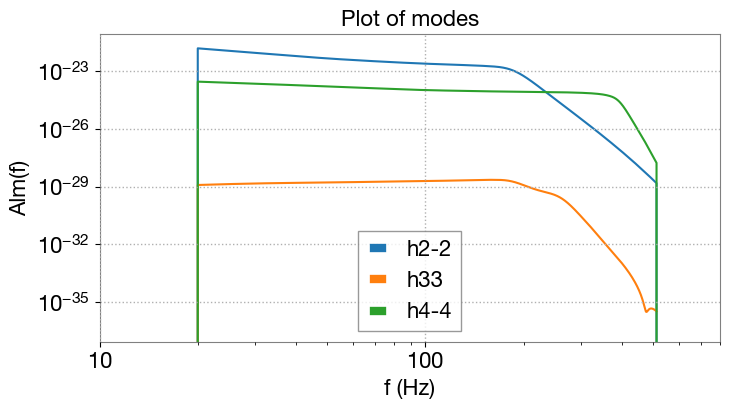

In [43]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(np.abs(hlm[(2,-2)]), label=r'h2-2')
ax.plot(np.abs(hlm[(3,3)]), label=r'h33')
ax.plot(np.abs(hlm[(4,-4)]), label=r'h4-4')

ax.set_xlim(10., 800.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'Alm(f)')
ax.set_title(r'Plot of modes')
ax.legend(loc='best');

# fig.tight_layout()

## FFT/IFFT and conditioning

In [129]:
test = np.fft.fft(hlm[(2,-2)])

In [130]:
hlm[(2,-2)]

array([ 3.14435005e-22+0.00000000e+00j,
        3.14125819e-22+1.44669451e-23j,
        3.13151176e-22+2.89071167e-23j, ...,
       -5.13272340e-40-1.00518453e-39j,
        2.98396784e-40-9.54126144e-40j,
        7.80258006e-40-4.18660648e-40j])

In [131]:
test

array([1.92154322e-22+6.83460534e-21j,
       1.85064169e-22+7.13894760e-21j,
       1.70126198e-22+7.45961105e-21j, ...,
       1.50900810e-22+6.06456567e-21j,
       1.71341303e-22+6.29271004e-21j,
       1.87191925e-22+6.55060219e-21j])

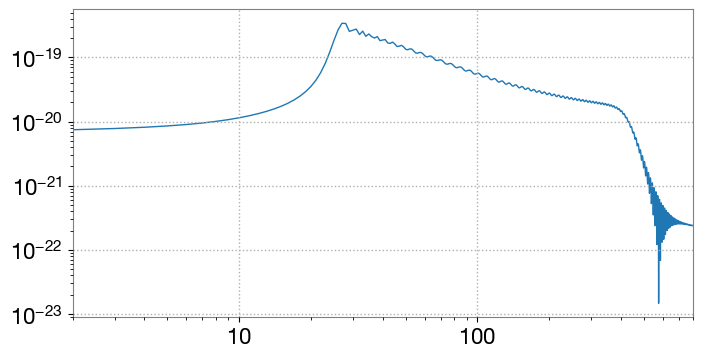

In [133]:
fig, ax = plt.subplots(1,1, figsize=[8,4])

ax.plot(np.abs(test), label=r'')

ax.set_xlim(2., 800.)
ax.set_xscale('log')
ax.set_yscale('log')

# Part II: visualizing data

## Load data with gwosc and gwpy

In [2]:
from gwosc import datasets
from gwosc.datasets import find_datasets
from gwosc.datasets import event_gps

from gwpy.timeseries import TimeSeries

In [7]:
#-- List all available catalogs
print("List of available catalogs")
print(find_datasets(type="catalog"))

List of available catalogs
['GWTC', 'GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'GWTC-2.1-auxiliary', 'GWTC-2.1-confident', 'GWTC-2.1-marginal', 'GWTC-3-confident', 'GWTC-3-marginal', 'IAS-O3a', 'Initial_LIGO_Virgo', 'O1_O2-Preliminary', 'O3_Discovery_Papers', 'O3_IMBH_marginal', 'O4_Discovery_Papers']


In [11]:
GWTC1_confident_events = datasets.find_datasets(type='events', catalog='GWTC-1-confident')
GWTC2_confident_events = datasets.find_datasets(type='events', catalog='GWTC-2.1-confident')
GWTC3_confident_events = datasets.find_datasets(type='events', catalog='GWTC-3-confident')

len(GWTC1_confident_events), len(GWTC2_confident_events), len(GWTC3_confident_events)

(11, 44, 35)

In [12]:
GWTC1_confident_events

['GW150914-v3',
 'GW151012-v3',
 'GW151226-v2',
 'GW170104-v2',
 'GW170608-v3',
 'GW170729-v1',
 'GW170809-v1',
 'GW170814-v3',
 'GW170817-v3',
 'GW170818-v1',
 'GW170823-v1']

### GW150914

In [9]:
t_gps = event_gps('GW150914')
print(t_gps)

1126259462.4


In [156]:
H1_data = TimeSeries.read('./data/GW150914/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")
L1_data = TimeSeries.read('./data/GW150914/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', format="hdf5.gwosc")

### GW170814

In [15]:
gps = event_gps('GW170814')
print(gps)

1186741861.5


In [17]:
H1_data = TimeSeries.read('./data/GW170814/H-H1_GWOSC_4KHZ_R1-1186741846-32.hdf5', format="hdf5.gwosc")
L1_data = TimeSeries.read('./data/GW170814/L-L1_GWOSC_4KHZ_R1-1186741846-32.hdf5', format="hdf5.gwosc")
V1_data = TimeSeries.read('./data/GW170814/V-V1_GWOSC_4KHZ_R1-1186741846-32.hdf5', format="hdf5.gwosc")

### GW170817

In [3]:
gps = event_gps('GW170817')
print(gps)

1187008882.4


In [4]:
H1_data = TimeSeries.read('./data/GW170817/H-H1_GWOSC_4KHZ_R1-1187008867-32.hdf5', format="hdf5.gwosc")
L1_data = TimeSeries.read('./data/GW170817/L-L1_GWOSC_4KHZ_R1-1187008867-32.hdf5', format="hdf5.gwosc")
V1_data = TimeSeries.read('./data/GW170817/V-V1_GWOSC_4KHZ_R1-1187008867-32.hdf5', format="hdf5.gwosc")

In [15]:
# segment = (int(gps) - 30, int(gps) + 2)
# H1_data = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
# L1_data = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)
# V1_data = TimeSeries.fetch_open_data('V1', *segment, verbose=True, cache=True)

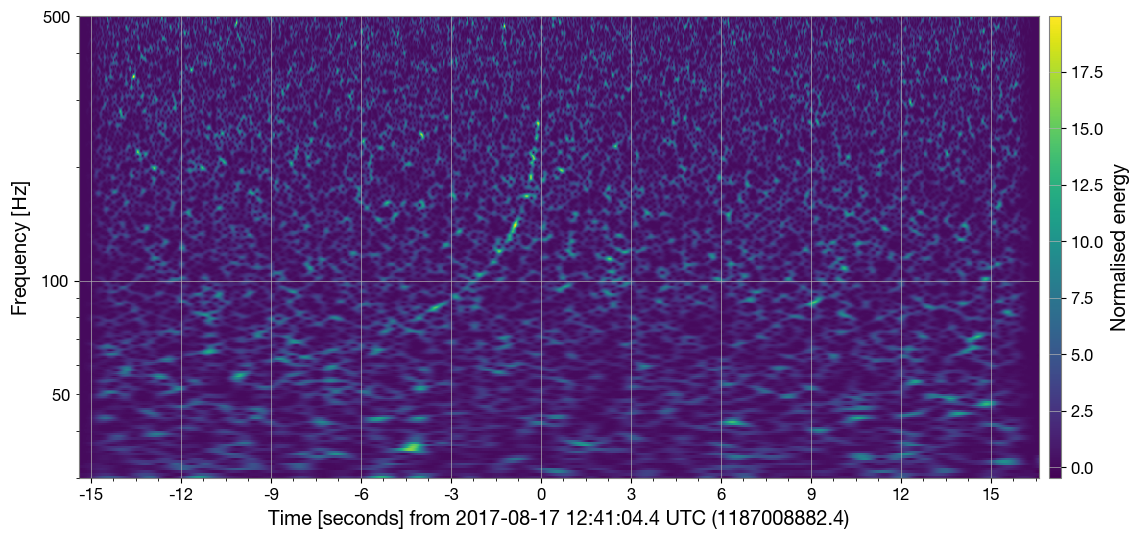

In [5]:
hq = H1_data.q_transform(frange=(30, 500), qrange=(100, 110))
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

## Strain data

In [17]:
# read in data from H1 and L1, if available:
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(losc_dir + fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(losc_dir + fn_L1, 'L1')

# Remove a constant shift of -1e-18 in the L1 strain, not sure why it's here
strain_L1 += 1e-18

In [18]:
# both H1 and L1 will have the same time vector, so:
# set t=0 at the middle of the interval
time = time_H1 - time_H1[len(time_H1)//2]
tevent = tevent - time_H1[len(time_H1)//2]
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

dt, 1./dt, time[-1] - time[0], len(time)

(np.float64(0.000244140625),
 np.float64(4096.0),
 np.float64(31.999755859375),
 131072)

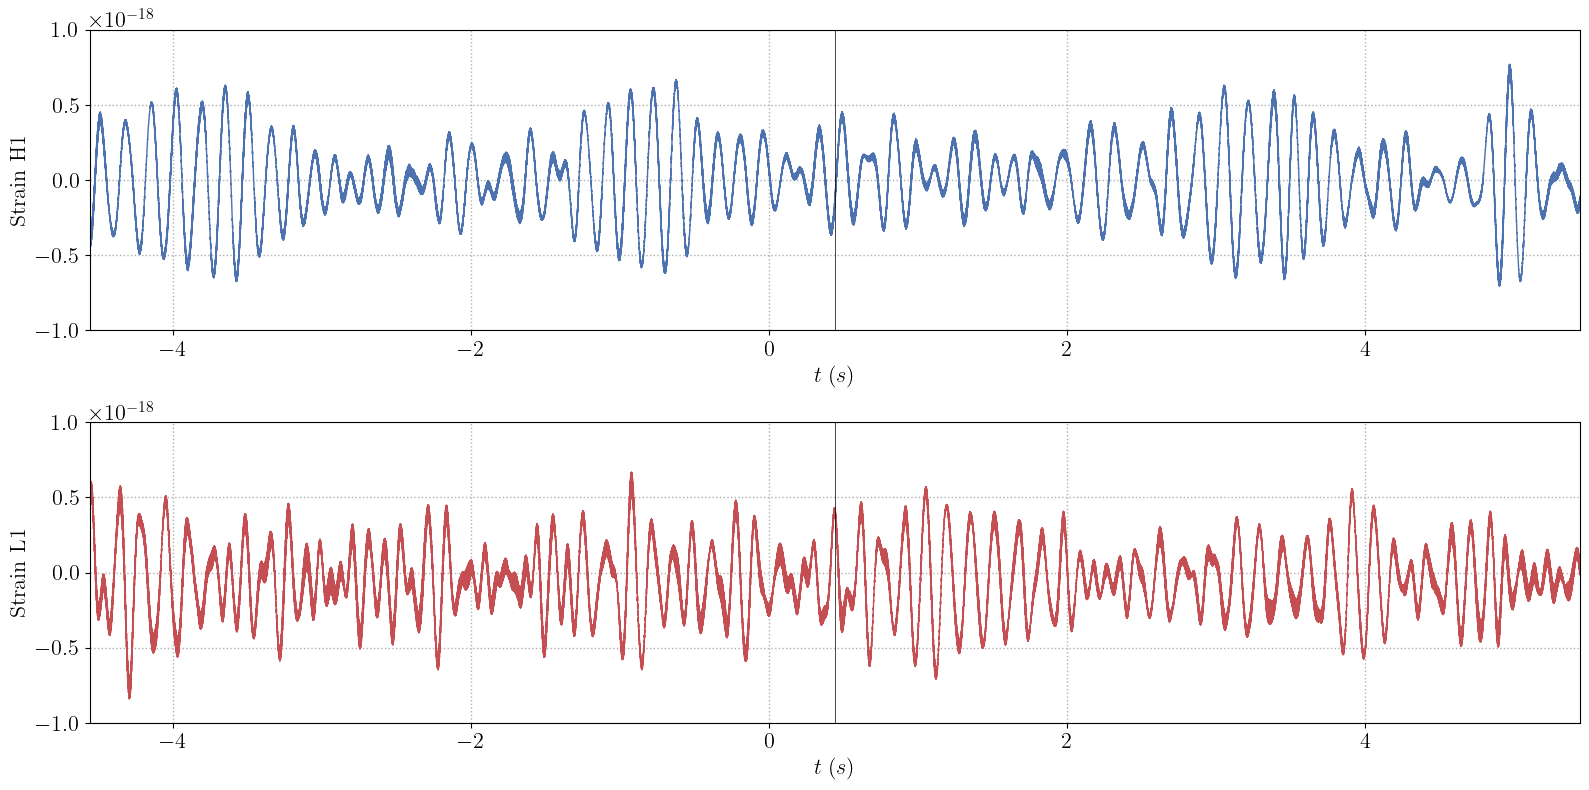

<Figure size 800x400 with 0 Axes>

In [269]:
deltat = 5
mask = (tevent - deltat <= time) & (time <= tevent + deltat)
rangey = [-1e-18, 1e-18]

fig, axs = plt.subplots(2,1, figsize=[16,8])
plotutils.lplot(axs[0], [time[mask], strain_H1[mask]], rangey=rangey)
plotutils.lplot(axs[1], [time[mask], strain_L1[mask]], colors=[plotutils.plotpalette[1]], rangey=rangey)
axs[0].set_ylabel(r'Strain H1')
axs[1].set_ylabel(r'Strain L1')
for i in range(2):
    axs[i].set_xlabel(r'$t \; (s)$')
    axs[i].axvline(tevent, c='k', lw=0.5)

fig.tight_layout()

fig.savefig('./plots/strain_raw_GW150914.pdf')

In [25]:
H1_data?

Type:        TimeSeries
String form:
TimeSeries([9.06730891e-21, 2.01178871e-20, 3.71290472e-20, ...,
           5.32101440e-20, 4.74 <...> 26259447.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)
Length:      131072
File:        ~/miniconda3/envs/odw/lib/python3.11/site-packages/gwpy/timeseries/timeseries.py
Docstring:  
A time-domain data array.

Parameters
----------
value : array-like
    input data array

unit : `~astropy.units.Unit`, optional
    physical unit of these data

t0 : `~gwpy.time.LIGOTimeGPS`, `float`, `str`, optional
    GPS epoch associated with these data,
    any input parsable by `~gwpy.time.to_gps` is fine

dt : `float`, `~astropy.units.Quantity`, optional
    time between successive samples (seconds), can also be given inversely
    via `sample_rate`

sample_rate : `float`, `~astropy.units.Quantity`, optional
    the rate of samples per second (Hertz), can also be given inversely
    via `dt`

times : `array-like`
    th

In [157]:
times = np.asarray(H1_data.times).copy()
# New origin of times: middle of our data interval
t_center = times[len(times)//2]
times -= t_center
tevent = t_gps - t_center
strain_H1 = np.asarray(H1_data).copy()
strain_L1 = np.asarray(L1_data).copy()

dt = H1_data.dt.value
fs = 1./dt
dt, fs, len(times)

(0.000244140625, 4096.0, 131072)

In [155]:
times = np.asarray(H1_data.times)
times

array([-16.        , -15.99975586, -15.99951172, ...,
        15.99926758,  15.99951172,  15.99975586])

In [147]:
times

array([-16.        , -15.99975586, -15.99951172, ...,
        15.99926758,  15.99951172,  15.99975586])

In [31]:
t_gps

1126259462.4

In [34]:
(t_gps - deltat), times[0]

(1126259457.4, 1126259447.0)

In [36]:
np.sum(mask)

40960

In [37]:
strain_H1[mask]

array([1.12625946e+09, 1.12625946e+09, 1.12625946e+09, ...,
       1.12625947e+09, 1.12625947e+09, 1.12625947e+09])

In [158]:
tevent

-0.5999999046325684

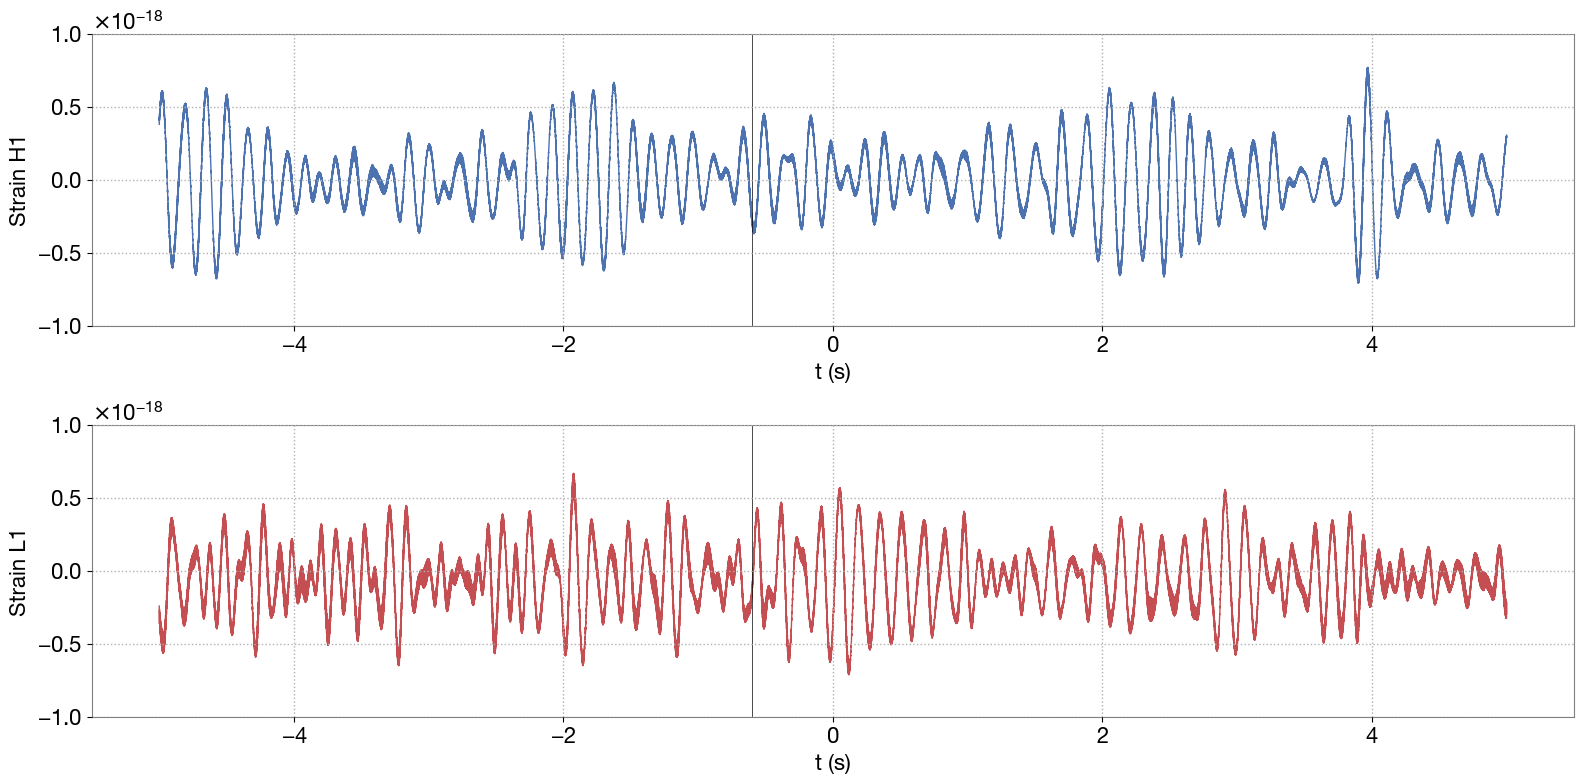

In [159]:
deltat = 5
mask = (-deltat <= times) & (times <= deltat)
ylim = [-1e-18, 1e-18]

fig, axs = plt.subplots(2,1, figsize=[16,8])
axs[0].plot(times[mask], strain_H1[mask], c=colors[0])
axs[1].plot(times[mask], strain_L1[mask] + 1e-18, c=colors[1])

axs[0].set_ylabel(r'Strain H1')
axs[1].set_ylabel(r'Strain L1')
for i in range(2):
    axs[i].set_ylim(ylim)
    axs[i].set_xlabel(r't (s)')
    axs[i].axvline(tevent, c='k', lw=0.5)

fig.tight_layout()

## Evaluate PSD

In [8]:
scipy.signal.welch?

Signature:
scipy.signal.welch(
    x,
    fs=1.0,
    window='hann',
    nperseg=None,
    noverlap=None,
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
    average='mean',
)
Docstring:
Estimate power spectral density using Welch's method.

Welch's method [1]_ computes an estimate of the power spectral
density by dividing the data into overlapping segments, computing a
modified periodogram for each segment and averaging the
periodograms.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window 

In [78]:
freqs_psd, psd_H1 = scipy.signal.welch(strain_H1, fs,  window='hann', nperseg=16384, scaling='density')
freqs_psd, psd_L1 = scipy.signal.welch(strain_L1, fs,  window='hann', nperseg=16384, scaling='density')

# We will use interpolations of the ASDs computed above for whitening:
psd_H1_interp = scipy.interpolate.interp1d(freqs_psd, psd_H1)
psd_L1_interp = scipy.interpolate.interp1d(freqs_psd, psd_L1)

In [76]:
psd_H1.shape, freqs_psd[1] - freqs_psd[0]

((8193,), 0.25)

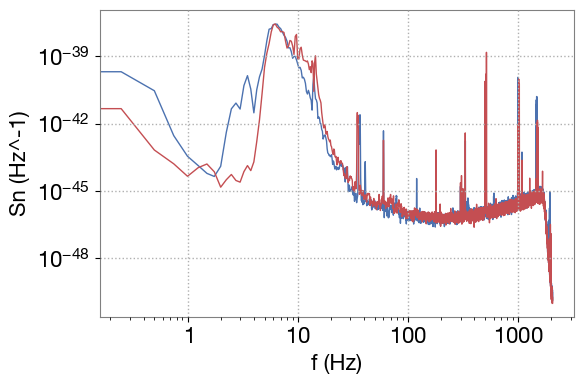

In [64]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(freqs_psd, psd_H1, c=colors[0], lw=1)
ax.loglog(freqs_psd, psd_L1, c=colors[1], lw=1)

# ax.set_xlim([5., 2048.])
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'Sn (Hz^-1)')

fig.tight_layout()

In [71]:
freqs_psd, psd_H1 = scipy.signal.welch(strain_H1, fs,  window='hann', nperseg=2048, scaling='density')
freqs_psd, psd_L1 = scipy.signal.welch(strain_L1, fs,  window='hann', nperseg=2048, scaling='density')

In [74]:
psd_H1.shape, freqs_psd[1] - freqs_psd[0]

((1025,), 2.0)

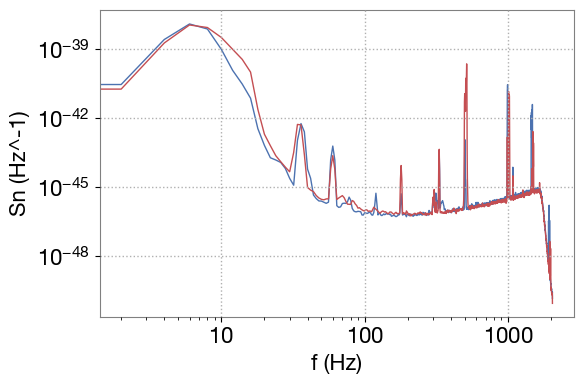

In [73]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(freqs_psd, psd_H1, c=colors[0], lw=1)
ax.loglog(freqs_psd, psd_L1, c=colors[1], lw=1)

# ax.set_xlim([5., 2048.])
ax.set_xlabel(r'f (Hz)')
ax.set_ylabel(r'Sn (Hz^-1)')

fig.tight_layout()

## Data visualization: tapering, band-passing, whitening, spectrogram

In [18]:
# Data selected to be +-2s around the event
# _d for 'data' that we are going to actually use

# n = 2**np.round(np.log2(4. / dt))
n = len(time)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
time_d = time[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(time_d), [time_d[0], time_d[-1]]

(131072, 32.0, 131072, [-16.0, 15.999755859375])

In [19]:
# Tapering data at both ends
# w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 0.5, 0.5)
w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 2., 2.)
strain_H1_tap = w * strain_H1_d
strain_L1_tap = w * strain_L1_d

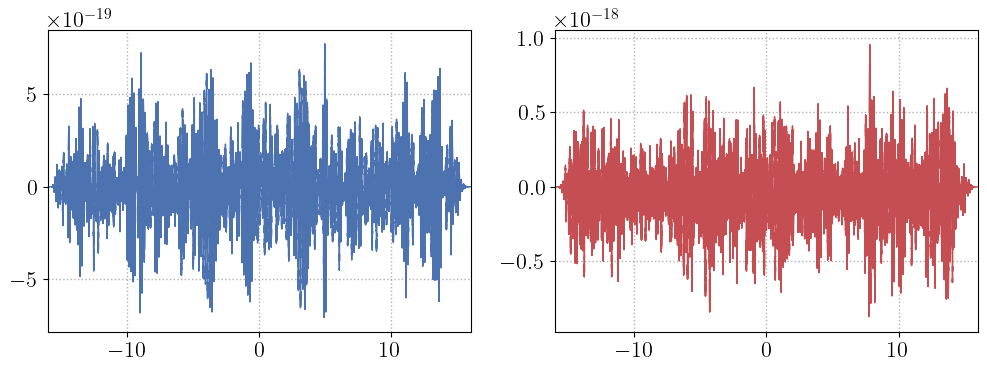

<Figure size 800x400 with 0 Axes>

In [282]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_tap])
plotutils.lplot(axs[1], [time_d, strain_L1_tap], colors=[plotutils.plotpalette[1]])

In [20]:
# Data FD
strain_H1_fd = pytools.fft_positivef(np.array([time_d, strain_H1_tap]).T)
strain_L1_fd = pytools.fft_positivef(np.array([time_d, strain_L1_tap]).T)

df = strain_H1_fd[1,0] - strain_H1_fd[0,0]
df

0.03125

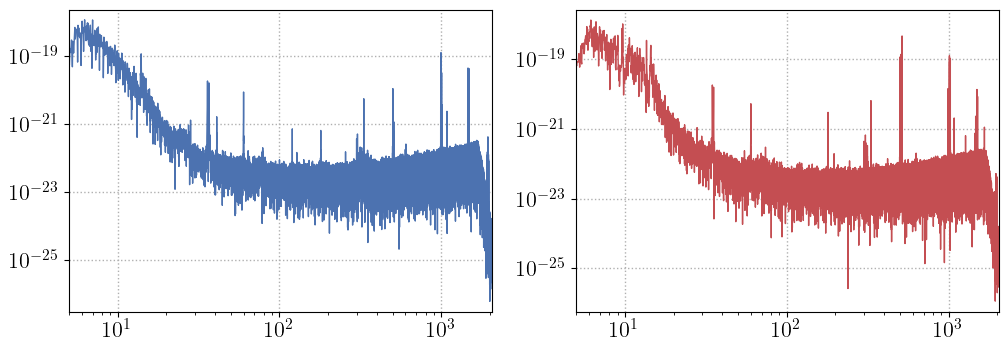

<Figure size 800x400 with 0 Axes>

In [284]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], np.abs(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

In [21]:
# Data band-passed first, before whitening

freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_bp_vals = w_fft * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
strain_L1_fd_bp_vals = w_fft * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_bp = np.array([freq_fft, np.real(strain_H1_fd_bp_vals), np.imag(strain_H1_fd_bp_vals)]).T
strain_L1_fd_bp = np.array([freq_fft, np.real(strain_L1_fd_bp_vals), np.imag(strain_L1_fd_bp_vals)]).T

strain_H1_td_bp = pytools.ifft_real(strain_H1_fd_bp)
strain_L1_td_bp = pytools.ifft_real(strain_L1_fd_bp)

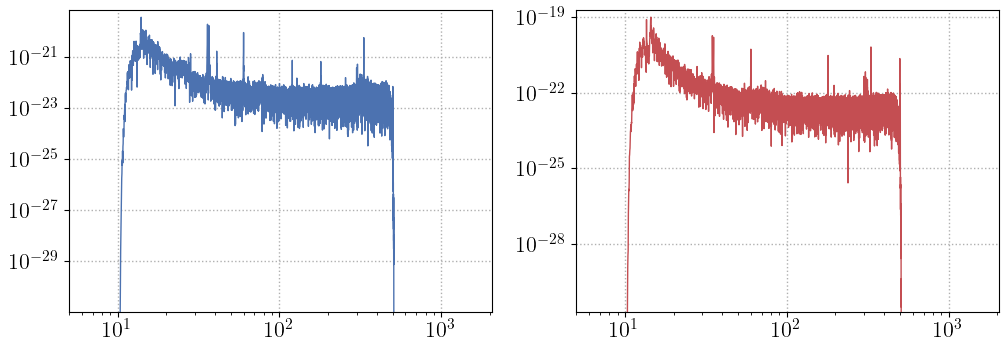

<Figure size 800x400 with 0 Axes>

In [286]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_bp[:,1] + 1j*strain_H1_fd_bp[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], np.abs(strain_L1_fd_bp[:,1] + 1j*strain_L1_fd_bp[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

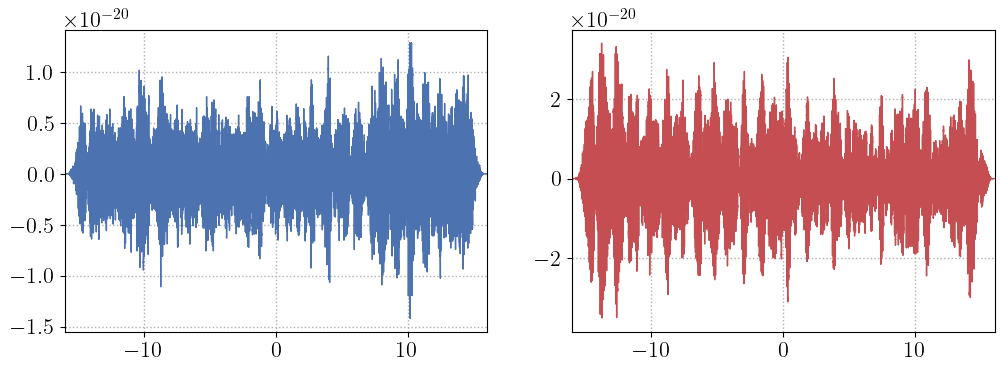

<Figure size 800x400 with 0 Axes>

In [287]:
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_bp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_L1_td_bp[:,1]], colors=[plotutils.plotpalette[1]])

In [22]:
# Data whitened after band-passing
freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_wbp_vals = 1./np.sqrt(psd_H1(freq_fft) / (2*df)) * (strain_H1_fd_bp[:,1] + 1j*strain_H1_fd_bp[:,2])
strain_L1_fd_wbp_vals = 1./np.sqrt(psd_L1(freq_fft) / (2*df)) * (strain_L1_fd_bp[:,1] + 1j*strain_L1_fd_bp[:,2])
# strain_H1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
# strain_L1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_wbp = np.array([freq_fft, np.real(strain_H1_fd_wbp_vals), np.imag(strain_H1_fd_wbp_vals)]).T
strain_L1_fd_wbp = np.array([freq_fft, np.real(strain_L1_fd_wbp_vals), np.imag(strain_L1_fd_wbp_vals)]).T

strain_H1_td_wbp = pytools.ifft_real(strain_H1_fd_wbp)
strain_L1_td_wbp = pytools.ifft_real(strain_L1_fd_wbp)

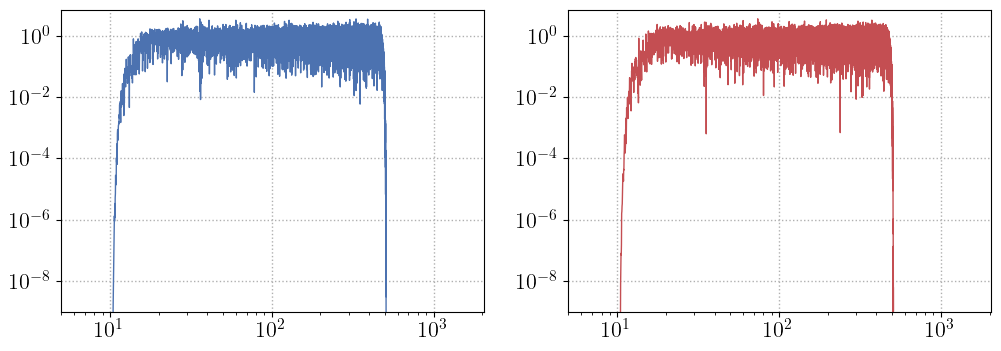

<Figure size 800x400 with 0 Axes>

In [376]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_wbp_vals)], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], np.abs(strain_L1_fd_wbp_vals)], colors=[plotutils.plotpalette[1]], rangex=rangex)

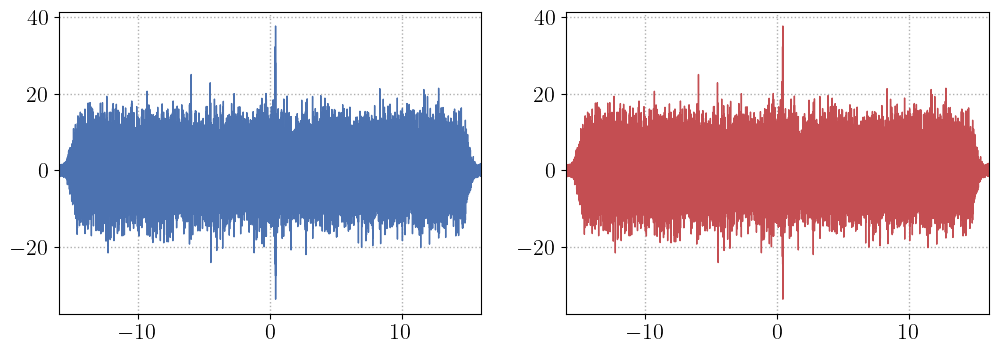

<Figure size 800x400 with 0 Axes>

In [289]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]])

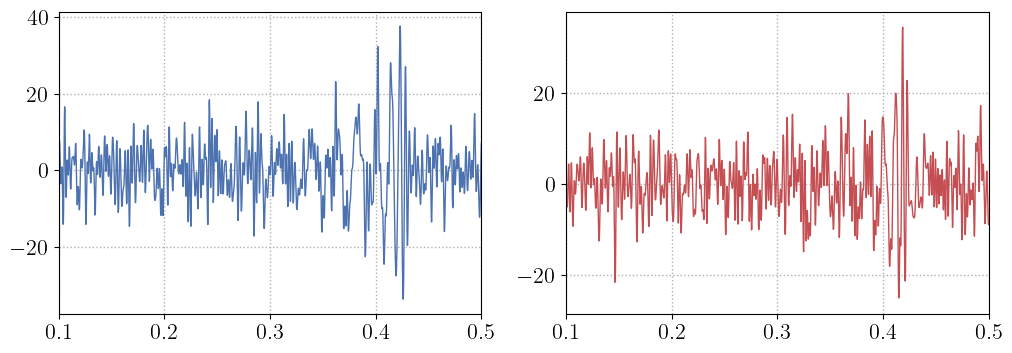

<Figure size 800x400 with 0 Axes>

In [293]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# rangex = [-0.3, 0.05]
rangex = [0.1, 0.5]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
plotutils.lplot(axs[1], [time_d, strain_L1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]], rangex=rangex)

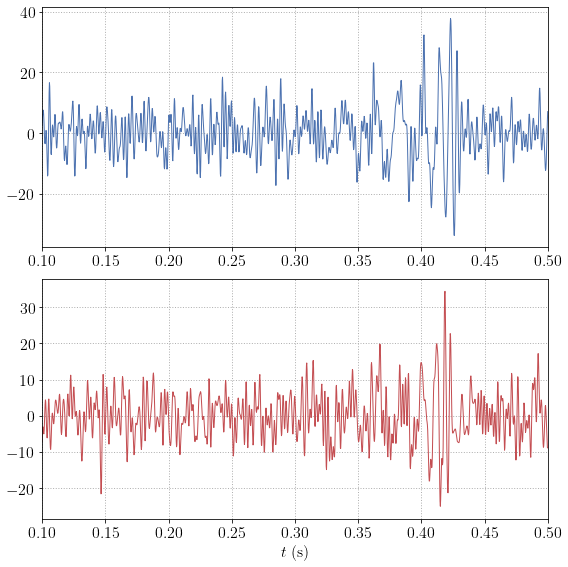

<Figure size 576x288 with 0 Axes>

In [40]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# rangex = [-0.3, 0.05]
rangex = [0.1, 0.5]

fig, axs = plt.subplots(2,1, figsize=[8,8])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
plotutils.lplot(axs[1], [time_d, strain_L1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]], rangex=rangex)

axs[1].set_xlabel(r'$t \; (\mathrm{s})$')

fig.tight_layout()

fig.savefig('./plots/data_td_wbp_zoom.pdf', dpi=300)

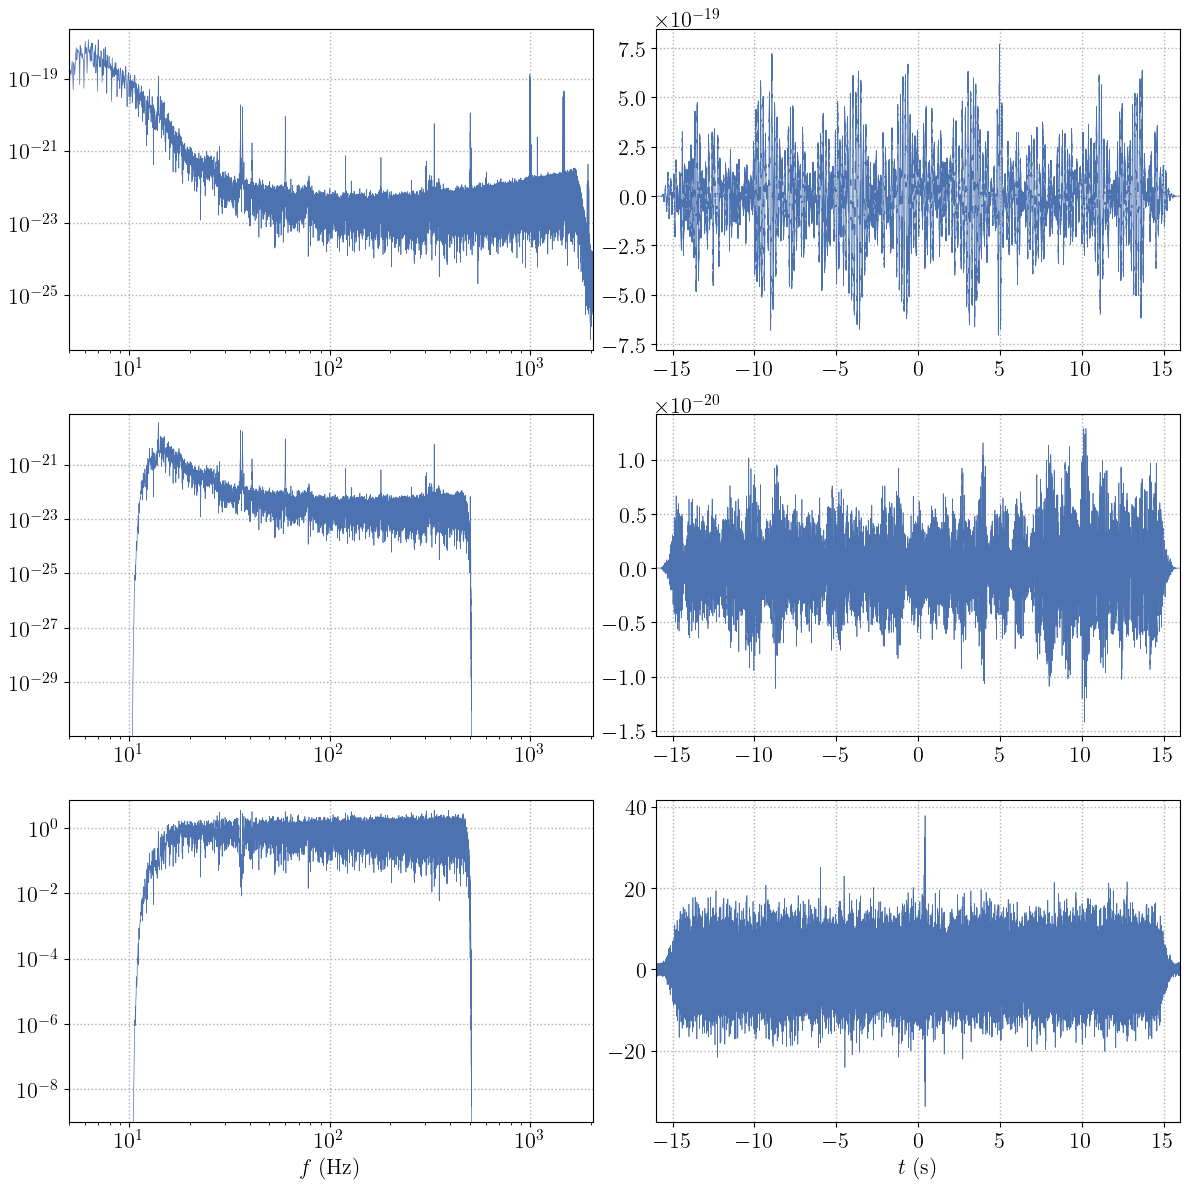

<Figure size 800x400 with 0 Axes>

In [391]:
rangex = [5., 2048.]

fig, axs = plt.subplots(3,2, figsize=[12,12])
plotutils.lplot(axs[0,1], [time_d, strain_H1_tap], linewidths=[0.5])
plotutils.lloglogplot(axs[0,0], [strain_H1_fd[:,0], np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex, linewidths=[0.5])
plotutils.lplot(axs[1,1], [time_d, strain_H1_td_bp[:,1]], linewidths=[0.5])
plotutils.lloglogplot(axs[1,0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_bp[:,1] + 1j*strain_H1_fd_bp[:,2])], rangex=rangex, linewidths=[0.5])
plotutils.lplot(axs[2,1], [time_d, strain_H1_td_wbp[:,1]], linewidths=[0.5])
plotutils.lloglogplot(axs[2,0], [strain_H1_fd[:,0], np.abs(strain_H1_fd_wbp_vals)], rangex=rangex, linewidths=[0.5])

axs[2,1].set_xlabel(r'$t \; (\mathrm{s})$')
axs[2,0].set_xlabel(r'$f \; (\mathrm{Hz})$')

fig.tight_layout()

fig.savefig('./plots/data_tdfd_bp_w.pdf', dpi=300)

### Devel

In [173]:
# Data whitened in TD
# NOTE: use smooth PSD here, otherwise problems when not band-passing, see plot below
freq_fft = strain_H1_fd[:,0]
# strain_H1_fd_w_vals = 1./np.sqrt(psd_H1(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
# strain_L1_fd_w_vals = 1./np.sqrt(psd_L1(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_w_vals = 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
strain_L1_fd_w_vals = 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_w = np.array([freq_fft, np.real(strain_H1_fd_w_vals), np.imag(strain_H1_fd_w_vals)]).T
strain_L1_fd_w = np.array([freq_fft, np.real(strain_L1_fd_w_vals), np.imag(strain_L1_fd_w_vals)]).T

strain_H1_td_w = pytools.ifft_real(strain_H1_fd_w)
strain_L1_td_w = pytools.ifft_real(strain_L1_fd_w)

In [171]:
dt, strain_H1_td_w[1,0] - strain_H1_td_w[0,0]

(0.000244140625, 0.000244140625)

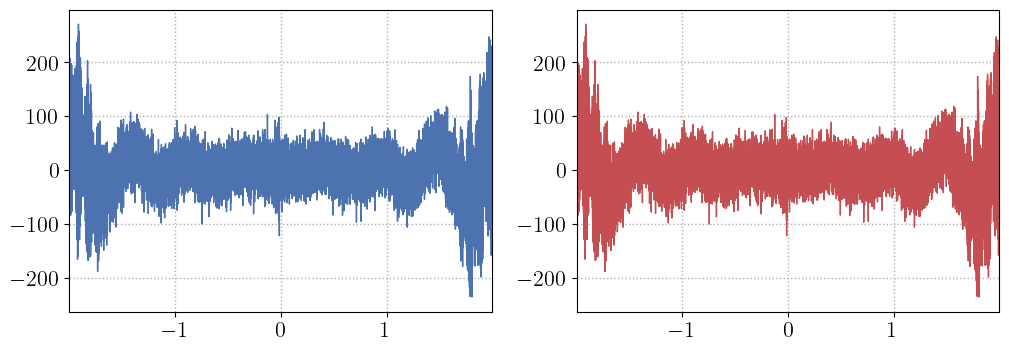

<Figure size 800x400 with 0 Axes>

In [172]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# fig, axs = plt.subplots(1,2, figsize=[12,4])
# plotutils.lplot(axs[0], [time_d, strain_H1_td_w[:,1]])
# plotutils.lplot(axs[1], [time_d, strain_H1_td_w[:,1]], colors=[plotutils.plotpalette[1]])

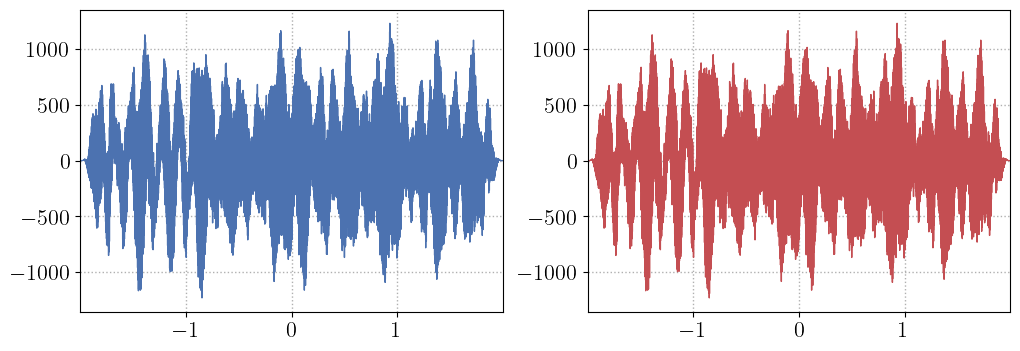

<Figure size 800x400 with 0 Axes>

In [174]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
# NOTE: with smooth noise, lines are not whitened and dominate
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_w[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_w[:,1]], colors=[plotutils.plotpalette[1]])

In [187]:
# Data whitened and band-passed in TD
# NOTE: use smooth PSD here, otherwise problems when not band-passing, see plot below
freq_fft = strain_H1_fd[:,0]
w_fft = pytools.window_planck_vec(freq_fft, 10., 512., 10., 64.)

strain_H1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_H1(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
strain_L1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_L1(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
# strain_H1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
# strain_L1_fd_wbp_vals = w_fft * 1./np.sqrt(psd_smooth(freq_fft) / (2*df)) * (strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])
strain_H1_fd_wbp = np.array([freq_fft, np.real(strain_H1_fd_wbp_vals), np.imag(strain_H1_fd_wbp_vals)]).T
strain_L1_fd_wbp = np.array([freq_fft, np.real(strain_L1_fd_wbp_vals), np.imag(strain_L1_fd_wbp_vals)]).T

strain_H1_td_wbp = pytools.ifft_real(strain_H1_fd_wbp)
strain_L1_td_wbp = pytools.ifft_real(strain_L1_fd_wbp)

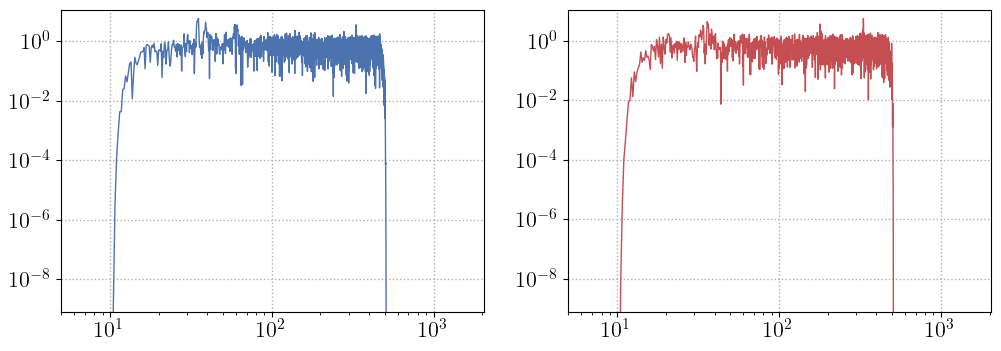

<Figure size 800x400 with 0 Axes>

In [185]:
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], w_fft * 2*df / np.sqrt(psd_H1(freq_fft)) * np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], w_fft * 2*df / np.sqrt(psd_L1(freq_fft)) * np.abs(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

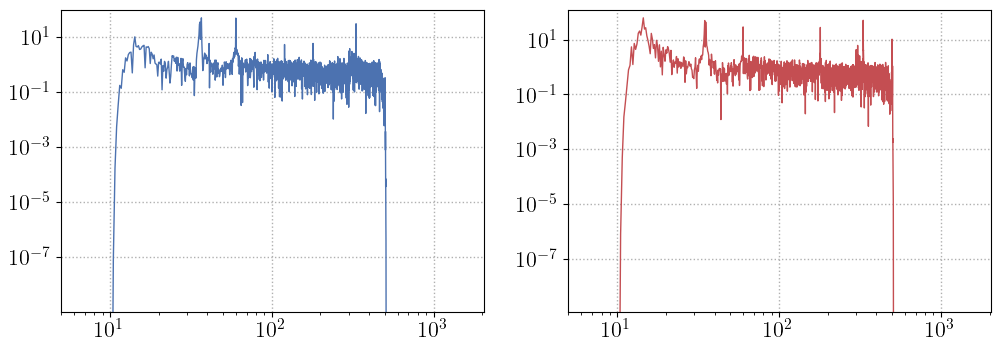

<Figure size 800x400 with 0 Axes>

In [182]:
# NOTE: problem when using the smooth PSD here, lines dominate
rangex = [5., 2048.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], [strain_H1_fd[:,0], w_fft * 2*df / np.sqrt(psd_smooth(freq_fft)) * np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(axs[1], [strain_L1_fd[:,0], w_fft * 2*df / np.sqrt(psd_smooth(freq_fft)) * np.abs(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])], colors=[plotutils.plotpalette[1]], rangex=rangex)

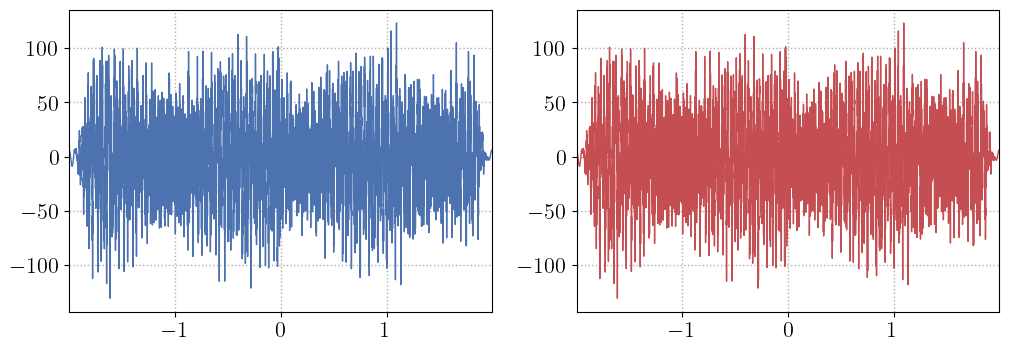

<Figure size 800x400 with 0 Axes>

In [180]:
# NOTE: problem when using the smooth PSD here, lines dominate
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]])

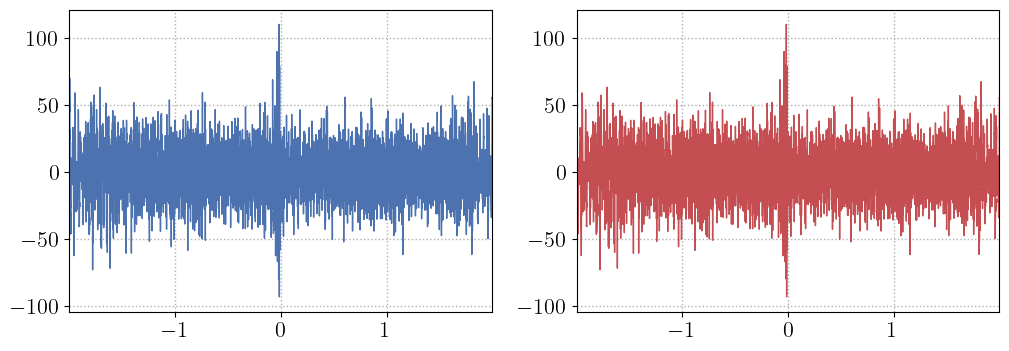

<Figure size 800x400 with 0 Axes>

In [188]:
# NOTE: problem when using esimated PSD, maybe due to fall-off at high-f ? Should band-pass anyway ?
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]])
plotutils.lplot(axs[1], [time_d, strain_H1_td_wbp[:,1]], colors=[plotutils.plotpalette[1]])

# Part III: matched filtering example

## Template from GWOSC

In [10]:
# read in the template (plus and cross) and parameters for the theoretical waveform
f_template = h5py.File(losc_dir + fn_template, "r")

# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

In [11]:
template_p.shape

(131072,)

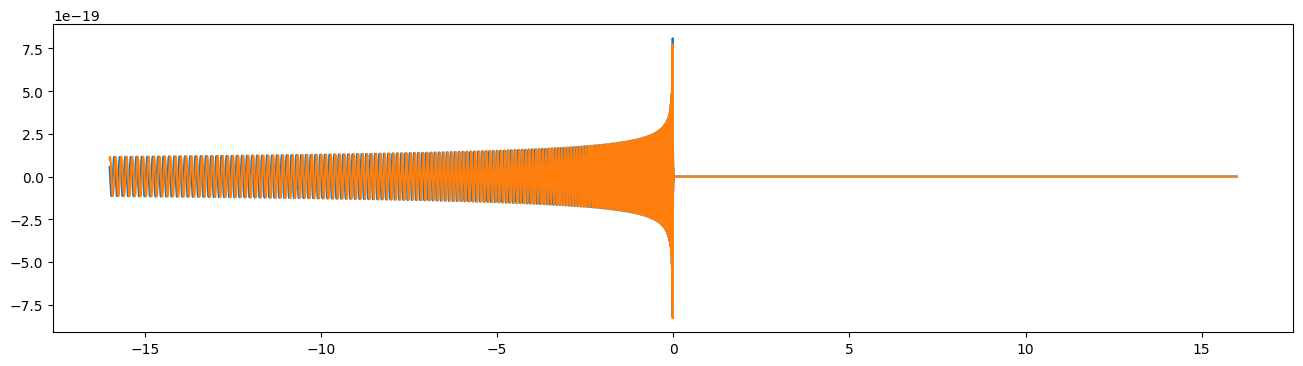

In [19]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
ax.plot(time, template_p)
ax.plot(time, template_c)

In [16]:
mask_0 = (template_p == 0.) & (template_c == 0.)
time[mask_0][0]

0.024169921875

In [17]:
template_t = time[~mask_0]
template_h = (template_p - 1j*template_c)[~mask_0]
template_amp = np.abs(template_h)
template_phase = np.unwrap(np.angle(template_h))

ipeak = np.argmax(template_amp)
tpeak = template_t[ipeak]

# Setting peak at t=0 for the template time vector
template_t -= tpeak

spline_phase = pytools.spline(template_t, template_phase)

tpeak, template_t[-1]

(-0.015869140625, 0.039794921875)

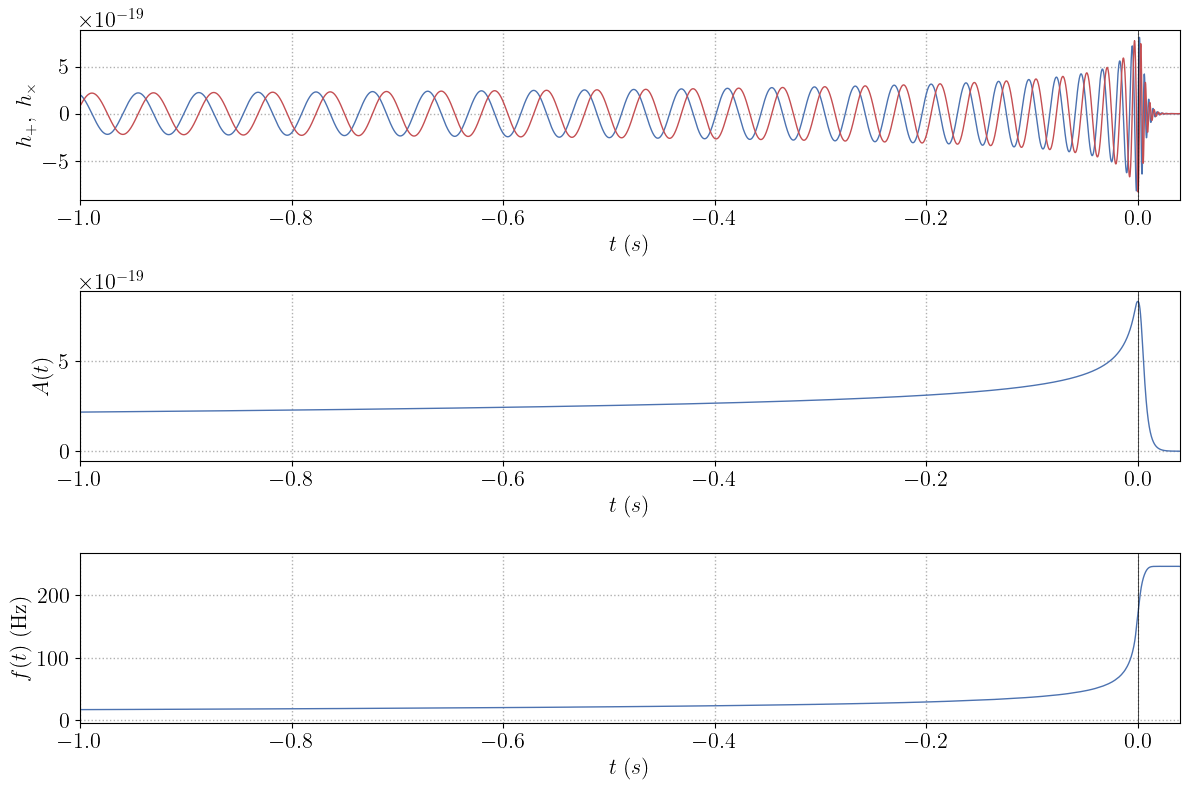

<Figure size 800x400 with 0 Axes>

In [279]:
rangex = [-1., template_t[-1]]

fig, axs = plt.subplots(3,1, figsize=[12,8])
plotutils.lplot(axs[0], [template_t, template_p[~mask_0]], [template_t, template_c[~mask_0]], rangex=rangex)
plotutils.lplot(axs[1], [template_t, template_amp], rangex=rangex)
plotutils.lplot(axs[2], [template_t, -1./(2*np.pi) * spline_phase(template_t, 1)], rangex=rangex)

for i in range(3):
    axs[i].set_xlabel(r'$t \; (s)$')
    axs[i].axvline(0., c='k', lw=0.5)
axs[0].set_ylabel(r'$h_+, \; h_\times$')
axs[1].set_ylabel(r'$A(t)$')
axs[2].set_ylabel(r'$f(t) \; (\mathrm{Hz})$')
    
fig.tight_layout()

fig.savefig('./plots/template_GW150914.pdf')

## Matched filter

In [160]:
# Data selected to be +-2s around the event
# _d for 'data' that we are going to actually use

# n = 2**np.round(np.log2(4. / dt))
n = len(times)
# mask_d = ( -n//2*dt <= time) & (time < n//2*dt)
mask_d = np.ones(n, dtype=bool)
times_d = times[mask_d]
strain_H1_d = strain_H1[mask_d]
strain_L1_d = strain_L1[mask_d]

n, n*dt, len(times_d), [times_d[0], times_d[-1]]

(131072, 32.0, 131072, [-16.0, 15.999755859375])

In [162]:
# Generate TD h2-2 template from best-guess masses
m1 = 34.6
m2 = 30.0

template_hlm = gwsignal_GenerateTDModes(m1, m2, [0., 0., 0.], [0., 0., 0.], f_min=5., f_ref=100.)[(2,-2)]

t, template = zeropad(template_hlm['t'], template_hlm[(2,-2)])

In [164]:
template.shape

(71102,)

In [23]:
# Template FD
# Tapering data at both ends
# Shift in time so that t=0 for templae is at tpeak
# w = pytools.window_planck_vec(time_d, time_d[0], time_d[-1], 0.5, 0.5)
w = pytools.window_planck_vec(times_d, times_d[0], times_d[-1], 2., 2.)
template_fd = fft_positivef(np.array([time_d, w * template_p[mask_d], -w * template_c[mask_d]]).T)

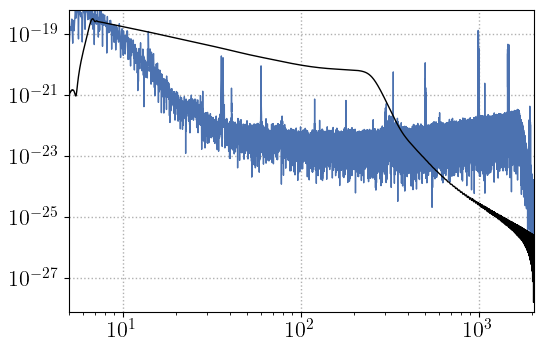

<Figure size 800x400 with 0 Axes>

In [298]:
#NOTE: amplitude of the template (which is arbitrary, we will normalize) is huge here it seems
rangex = [5., 2048.]

fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [strain_H1_fd[:,0], np.abs(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])], rangex=rangex)
plotutils.lloglogplot(ax, [template_fd[:,0], np.abs(template_fd[:,1] + 1j*template_fd[:,2])], colors=['k'], rangex=rangex)

In [24]:
# Frequencies bounds for inner product
mask = (10. < template_fd[:,0]) & (template_fd[:,0] < 1024.)
freq = template_fd[:,0]
w_fd = pytools.window_planck_vec(freq_fft, 5., 1024., 5., 128.)

In [25]:
# Wiener filter formed with this template
W_H1_fd = np.array([freq, w_fd * 2 / psd_H1(freq) * template_fd[:,1], w_fd * 2 / psd_H1(freq) * template_fd[:,2]]).T
W_L1_fd = np.array([freq, w_fd * 2 / psd_L1(freq) * template_fd[:,1], w_fd * 2 / psd_L1(freq) * template_fd[:,2]]).T

In [26]:
# Normalization: N = (h|h)
integrand_hh_H1 = w_fd * np.abs(template_fd[:,1] + 1j*template_fd[:,2])**2 / psd_H1(freq)
integrand_hh_L1 = w_fd * np.abs(template_fd[:,1] + 1j*template_fd[:,2])**2 / psd_L1(freq)
hh_H1 = 4*df * np.sum((integrand_hh_H1[1:] + integrand_hh_H1[:-1]) / 2)
hh_L1 = 4*df * np.sum((integrand_hh_L1[1:] + integrand_hh_L1[:-1]) / 2)
N_H1 = np.sqrt(hh_H1)
N_L1 = np.sqrt(hh_L1)
N_H1, N_L1

(31686.09292368623, 27414.265777006367)

In [27]:
# IFFT for time shifts
# Integrand: we compute (s|h) / sqrt((h|h)) = (s|h)/N with exp(+-2pi i f Deltat) (sign to check)
# NOTE: check the sign, here conjugation to make it work

# NOTE: factor 2 because we use ifft_positivef for a clearer impact of Deltaphi, but doing so we set negative frequencies to 0

integrand_H1 = w_fd * 1./N_H1 * (W_H1_fd[:,1] + 1j*W_H1_fd[:,2]) * np.conj(strain_H1_fd[:,1] + 1j*strain_H1_fd[:,2])
integrand_L1 = w_fd * 1./N_L1 * (W_L1_fd[:,1] + 1j*W_L1_fd[:,2]) * np.conj(strain_L1_fd[:,1] + 1j*strain_L1_fd[:,2])

# NOTE: mind the factor 2, because ifft_positivef sets negative frequencies to 0
ifft_H1_ts = 2 * pytools.ifft_positivef(np.array([template_fd[:,0], np.real(integrand_H1), -np.imag(integrand_H1)]).T)
ifft_L1_ts = 2 * pytools.ifft_positivef(np.array([template_fd[:,0], np.real(integrand_L1), -np.imag(integrand_L1)]).T)

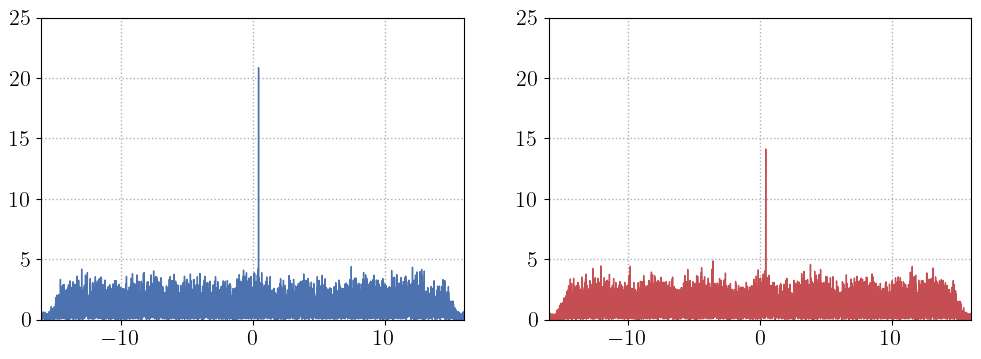

<Figure size 800x400 with 0 Axes>

In [343]:
# NOTE: this shows \rho optimized over phase shift, for different times shifts

rangex = None
rangey = [0., 25.]

fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lplot(axs[0], [time_d, np.abs(ifft_H1_ts[:,1] + 1j*ifft_H1_ts[:,2])], rangex=None, rangey=rangey)
plotutils.lplot(axs[1], [time_d, np.abs(ifft_L1_ts[:,1] + 1j*ifft_L1_ts[:,2])], rangex=None, rangey=rangey, colors=[plotutils.plotpalette[1]])

In [28]:
# PROBLEM: abs value from optimization over phase -- what is the expected distribution ?

mask_test = (-12 < time_d) & (time_d < 0.)
np.mean(np.abs(ifft_H1_ts[mask_test,1] + 1j*ifft_H1_ts[mask_test,2])**2), np.mean(np.abs(ifft_L1_ts[mask_test,1] + 1j*ifft_L1_ts[mask_test,2])**2)

(2.1444979212605615, 2.119932787647866)

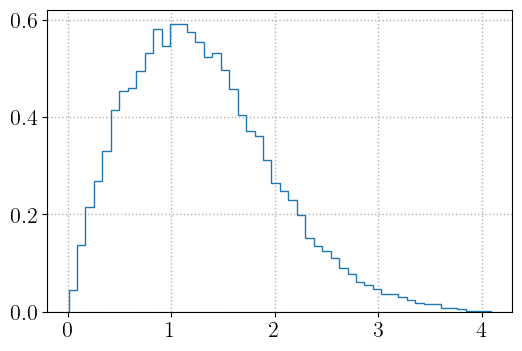

In [393]:
# NOTE: distribution of \rho optimized 

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(np.abs(ifft_H1_ts[mask_test,1] + 1j*ifft_H1_ts[mask_test,2]), histtype='step', density=True);

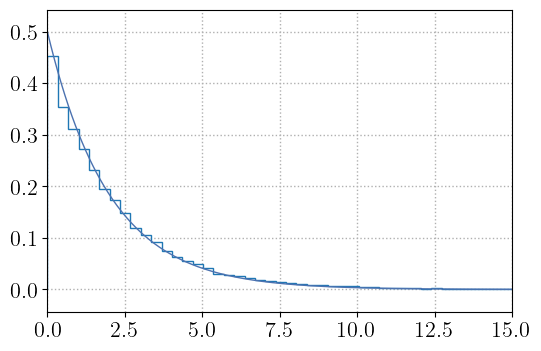

<Figure size 800x400 with 0 Axes>

In [395]:
# NOTE: distribution of \rho^2=R optimized, chi2 with 2 degrees of freedom

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(np.abs(ifft_H1_ts[mask_test,1] + 1j*ifft_H1_ts[mask_test,2])**2, histtype='step', density=True);

Rvals = np.linspace(0., 15., 400)
plotutils.lplot(ax, [Rvals, 1./2*np.exp(-Rvals/2)])

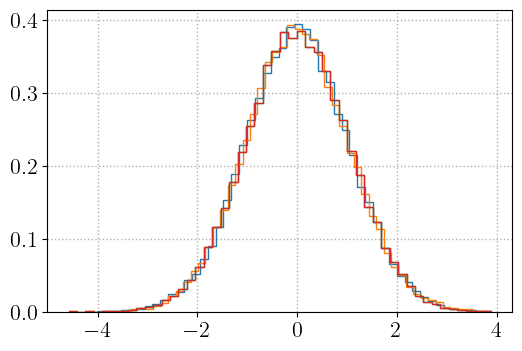

In [351]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(ifft_H1_ts[mask_test,1], histtype='step', density=True);
ax.hist(ifft_H1_ts[mask_test,2], histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,2], histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,2], histtype='step', density=True);

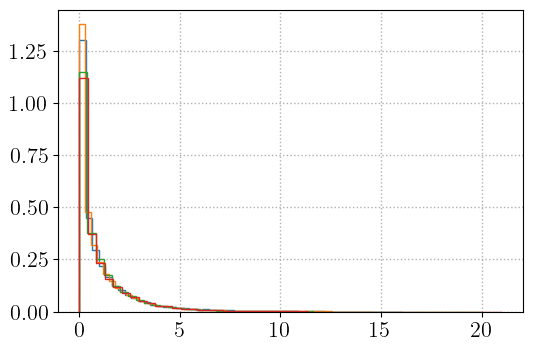

In [352]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(ifft_H1_ts[mask_test,1]**2, histtype='step', density=True);
ax.hist(ifft_H1_ts[mask_test,2]**2, histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,1]**2, histtype='step', density=True);
ax.hist(ifft_L1_ts[mask_test,2]**2, histtype='step', density=True);

In [349]:
np.std(ifft_H1_ts[mask_test,1]), np.std(ifft_H1_ts[mask_test,2])

(1.0354781042631842, 1.0355109925513837)

## Plot for distribution of SNR^2

In [364]:
SNR = np.sqrt(16)
Rbar = SNR**2

Rvals = np.linspace(0., 30., 400)
p_n = 1./2 * np.exp(-1./2*Rvals)
p_s = 1./2 * np.exp(-1./2*(Rvals+Rbar)) * scipy.special.iv(0, np.sqrt(Rvals * Rbar))

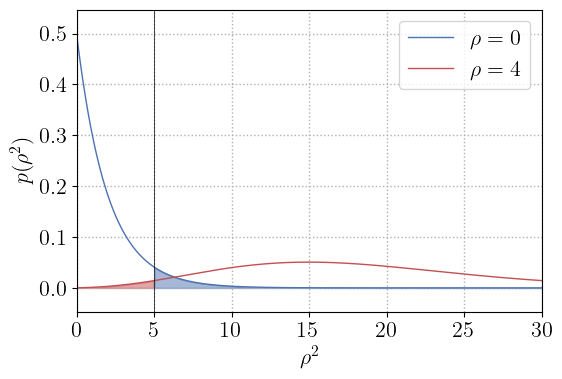

<Figure size 800x400 with 0 Axes>

In [375]:
Rthres = 5

fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lplot(ax, [Rvals, p_n], [Rvals, p_s], labels=[r'$\rho=0$', r'$\rho=4$'])
ax.fill_between(Rvals[Rvals > Rthres], 0., p_n[Rvals > Rthres], color=plotutils.plotpalette[0], alpha=0.5)
ax.fill_between(Rvals[Rvals < Rthres], 0., p_s[Rvals < Rthres], color=plotutils.plotpalette[1], alpha=0.5)
ax.axvline(Rthres, c='k', lw=0.5)
ax.set_xlabel(r'$\rho^2$')
ax.set_ylabel(r'$p(\rho^2)$')

ax.legend(loc='upper right')

fig.savefig('./plots/p_of_rho2.pdf')

## Plot for white noise

In [116]:
deltax = 1./4096
x = np.arange(-5., 5., deltax)

white_noise = np.random.normal(0, 1., size=len(x))

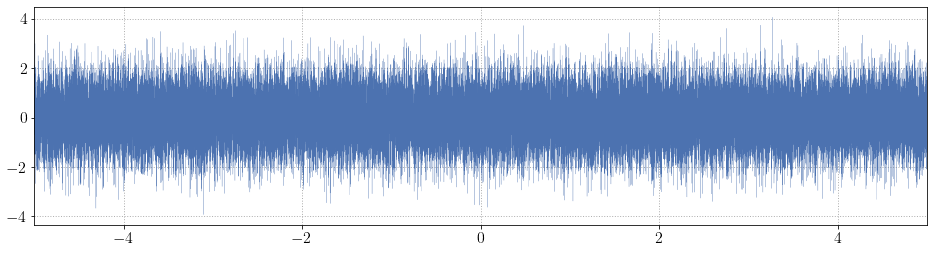

<Figure size 576x288 with 0 Axes>

In [119]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
plotutils.lplot(ax, [x, white_noise], linewidths=[0.2])

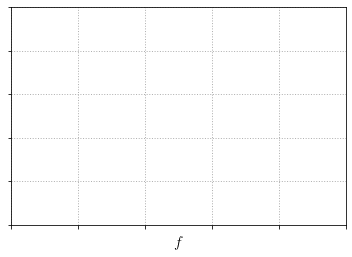

In [122]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_xlabel(r'$f$')
ax.set_xticklabels('');
ax.set_yticklabels('');

# Video

In [ ]:
# def generate_video(img):
#     for i in xrange(len(img)):
#         plt.imshow(img[i], cmap=cm.Greys_r)
#         plt.savefig(folder + "/file%02d.png" % i)
# 
#     os.chdir("your_folder")
#     subprocess.call([
#         'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
#         'video_name.mp4'
#     ])
#     for file_name in glob.glob("*.png"):
#         os.remove(file_name)

# Needed also https://stackoverflow.com/questions/20847674/ffmpeg-libx264-height-not-divisible-by-2

# Final command:

# ffmpeg -framerate 20 -i signal_rho_frame_%04d.png -pix_fmt yuv420p -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" video_signal_rho.mp4

In [53]:
alpha_td = np.arctan2(ifft_H1_ts[:,2], ifft_H1_ts[:,1])
A_td = np.abs(ifft_H1_ts[:,1] + 1j*ifft_H1_ts[:,2]) / N_H1

rho = np.abs(ifft_H1_ts[:,1] + 1j*ifft_H1_ts[:,2])
iopt = np.argmax(rho)
A_opt = A_td[iopt]
alpha_opt = alpha_td[iopt]
Deltat_opt = time_d[iopt]

In [55]:
A_opt, alpha_opt, Deltat_opt

(0.0006578358337716319, -2.240744996338205, 0.439453125)

In [73]:
freq_fft = strain_H1_fd[:,0]
mask_ext = (5. < freq_fft) & (freq_fft < 1024.)
freq_ext = freq_fft[mask_ext]

def htemplate_wbp_td(A, Deltat, alpha):
    w_ifft = pytools.window_planck_vec(freq_ext, 5., 1024., 5., 128.)
    h_fd = np.zeros_like(freq_fft, dtype=complex)
    h_fd[mask_ext] = w_ifft * A * np.exp(1j*alpha) * np.exp(2*1j*np.pi*freq_fft[mask_ext]*Deltat) * (template_fd[mask_ext,1] + 1j*template_fd[mask_ext,2])
    h_wbp_fd =  1./np.sqrt(psd_H1(freq_fft) / (2*df)) * h_fd 
    return pytools.ifft_real(np.array([freq_fft, np.real(h_wbp_fd), np.imag(h_wbp_fd)]).T)

In [74]:
ht_wbp_opt = htemplate_wbp_td(A_opt, Deltat_opt, alpha_opt)

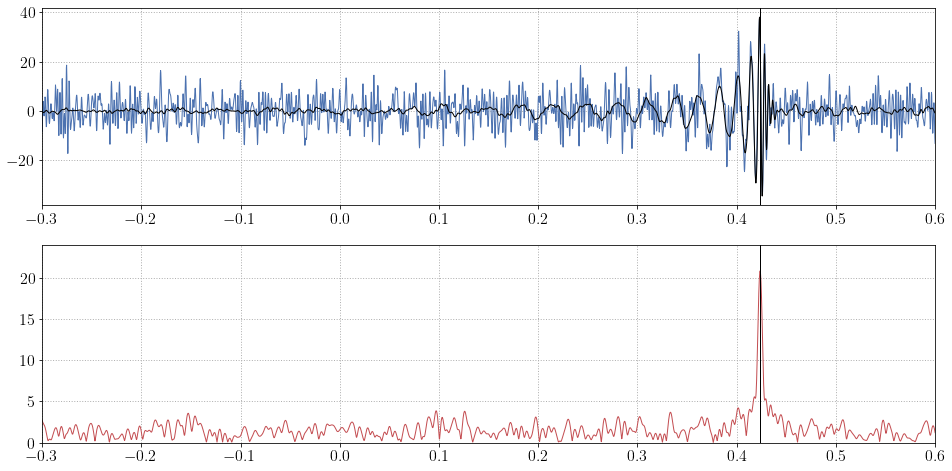

<Figure size 576x288 with 0 Axes>

In [89]:
# Take into account tpeak in Deltat_tot: template was not peaked at t=0 originally

rangex = [-0.3, 0.6]

fig, axs = plt.subplots(2,1, figsize=[16,8])
plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex)
plotutils.lplot(axs[0], [time_d, ht_wbp_opt[:,1]], rangex=rangex, colors=['k'])

plotutils.lplot(axs[1], [time_d + tpeak, rho], rangex=rangex, rangey=[0., 24.], colors=[plotutils.plotpalette[1]])

for i in range(2):
    axs[i].axvline(Deltat_opt + tpeak, c='k', lw=1.)

In [80]:
mask_plt = (-0.3 < time_d) & (time_d < 0.6)
time_d[mask_plt].shape, time_d[mask_plt].shape[0]//20

((3686,), 184)

In [83]:
# 20s of video, 20 fps
time_d[mask_plt].shape[0] / 400.

9.215

In [114]:
rangex = [-0.3, 0.6]

def plt_signal_rho(itime, iframe):
    Deltat = time_d[itime]
    A = A_td[itime]
    alpha = alpha_td[itime]
    ht_wbp = htemplate_wbp_td(A, Deltat, alpha)
    
    fig, axs = plt.subplots(2,1, figsize=[16,8]);
    plotutils.lplot(axs[0], [time_d, strain_H1_td_wbp[:,1]], rangex=rangex, rangey=[-40., 40.])
    plotutils.lplot(axs[0], [time_d, ht_wbp[:,1]], rangex=rangex, rangey=[-40., 40.], colors=['k'])

    plotutils.lplot(axs[1], [time_d + tpeak, rho], rangex=rangex, rangey=[0., 24.], colors=[plotutils.plotpalette[1]])
    
    for i in range(2):
        axs[i].axvline(Deltat_opt + tpeak, c='k', lw=2.)
        axs[i].axvline(Deltat + tpeak, c='k', lw=2., ls='--')
        
    axs[1].set_xlabel(r'$t \; (\mathrm{s})$')
        
    fig.tight_layout()
    
    fig.savefig('./videos/signal_rho_frame_%04d.png' % iframe, dpi=200)
    
    plt.close(fig)

In [115]:
ds = 9
inds = np.arange(len(time_d))[mask_plt]
inds_ds = inds[::ds]

for iframe in tqdm(range(len(inds_ds))):
    itime = inds_ds[iframe]
    plt_signal_rho(itime, iframe)

100%|███████████████████████████████████████████████████████████████████████████████████| 410/410 [03:43<00:00,  1.84it/s]


<Figure size 576x288 with 0 Axes>